In [1]:
try:
    import base64
    import io
    import json

    import google.colab  # noqa: F401
    import torch

    %pip install -q dataeval[torch]==v0.67.0
    !export LC_ALL="en_US.UTF-8"
    !export LD_LIBRARY_PATH="/usr/lib64-nvidia"
    !export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
    !ldconfig /usr/lib64-nvidia

    # Code below is to download the pretrained model weights stored on github
    !mkdir models
    !curl -o gitlfsbinary https://api.github.com/repos/aria-ml/dataeval/git/blobs/ad520d5589fdc49830f98d28aa5eaed0bbdfe5cb

    with open("gitlfsbinary") as f:
        rawfile = json.load(f)

    binaryfile = base64.b64decode(rawfile["content"])
    buffer = io.BytesIO(binaryfile)

    temp = torch.load(buffer, weights_only=False)
    torch.save(temp, "models/ae")

    del rawfile
    del binaryfile
    del buffer
    del temp
except Exception:
    pass

%pip install -q tabulate

/workspaces/dataeval/.tox/docs/bin/python3: No module named pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
import math

import matplotlib.pyplot as plt  # type: ignore
import numpy as np
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
from sklearn.manifold import TSNE  # type: ignore

from dataeval.metrics.bias import coverage


In [3]:
# We train a 10-d autoencoder on MNIST data for 1000 epochs with batch size 128
num_epochs = 1000
batch_size = 128

# Set seeds
torch.manual_seed(14)

# MNIST with mean 0 unit variance
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
trainset = torch.utils.data.Subset(trainset, range(2000))
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

In [4]:
# Define model architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # 28 x 28
            nn.Conv2d(1, 4, kernel_size=5),
            # 4 x 24 x 24
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(True),
            # 8 x 20 x 20 = 3200
            nn.Flatten(),
            nn.Linear(3200, 10),
            # 10
            nn.Sigmoid(),
        )
        self.decoder = nn.Sequential(
            # 10
            nn.Linear(10, 400),
            # 400
            nn.ReLU(True),
            nn.Linear(400, 4000),
            # 4000
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            # 10 x 20 x 20
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            # 24 x 24
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            # 28 x 28
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        return x

In [5]:
sd = torch.load("models/ae")
model = Autoencoder()
model.load_state_dict(sd)

<All keys matched successfully>

In [6]:
# Get images to predict on and predict
pred = [trainset[i][0] for i in range(2000)]
label = np.array([trainset[i][1] for i in range(2000)])
mod_preds = model.encode(torch.stack(pred)).detach().numpy()

In [7]:
# Visualize 10d as 2d with TSNE
tsne = TSNE(n_components=2)
red_dim = tsne.fit_transform(mod_preds)

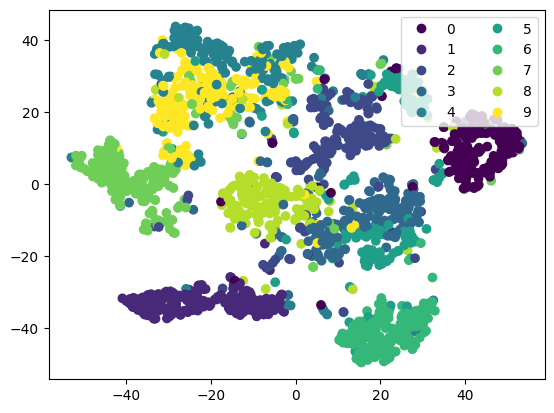

In [8]:
# Plot results with color being label
fig, ax = plt.subplots()
scatter = ax.scatter(
    x=red_dim[:, 0],
    y=red_dim[:, 1],
    c=label,
    label=label,
)
ax.legend(*scatter.legend_elements(), loc="upper right", ncols=2)
plt.show()

In [9]:
# Way to calculate data-agnostic radius (probably don't want to do this)
k = 20
n = 2000
d = 10
rho = (1 / math.sqrt(math.pi)) * ((4 * 20 * math.gamma(d / 2 + 1)) / (n)) ** (1 / d)

# Way to calculate data-adaptive radius (most extreme 1% are uncovered)
percent = 0.01
cutoff = int(n * percent)

In [10]:
# Use data adaptive cutoff
cvrg = coverage(mod_preds, radius_type="adaptive")

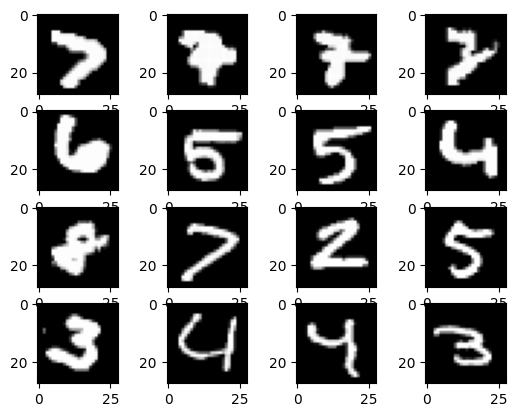

In [11]:
# Plot the least covered 0.5%
f, axs = plt.subplots(4, 4)
axs = axs.flatten()
for count, i in enumerate(axs):
    i.imshow(np.squeeze(pred[cvrg.indices[count]].numpy()), cmap="gray")